In [1]:
import torch
from torch.utils.data import DataLoader, RandomSampler, Dataset
from torch import nn
from torch.nn.functional import cross_entropy
from torch.optim import AdamW

from typing import List
from transformers import ElectraModel, ElectraTokenizer, get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.cuda.is_available()

True

In [3]:
bert_model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [4]:
df_name = glob.glob('../xlsx_data/category/#2_html2text/*/')

df_list = [pd.DataFrame() for i in range(7)]

for i, d in enumerate(df_name):
    for f in glob.glob(d+"/*/*.xlsx"):
        df = pd.read_excel(f)
        df_list[i] = df_list[i].append(df,ignore_index=True)
    df_list[i]['label'] = i

df_all = pd.concat(df_list, ignore_index=True)
df_all['total'] = df_all['title'].str.strip() + ".\n" + df_all['text'].str.strip()
df_all = df_all.fillna('')

In [5]:
batch_size = 128
epochs = 100
patience = 3

In [6]:
class CategoryDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer):
        # 데이터 셋이 가져야 하는 기본적인 값들을 세팅하는 함수
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        assert len(texts) == len(labels)

    def __getitem__(self, index:int):
        # bert입력을 만들어 주는 곳
        text = self.texts[index]
        label = self.labels[index]
        bert_inputs = self.tokenizer(text, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
    
        bert_inputs["input_ids"] = bert_inputs["input_ids"].squeeze()
        bert_inputs["attention_mask"] = bert_inputs["attention_mask"].squeeze()
        bert_inputs["token_type_ids"] = bert_inputs["token_type_ids"].squeeze()
    
        bert_inputs["label"] = torch.tensor(label, dtype=torch.long)
        return bert_inputs
  
    def __len__(self) -> int:
        # 이 데이터셋의 크기
        return len(self.texts)

In [7]:
class CategoryClassificationModel(nn.Module):
    def __init__(self, bert):
        super().__init__()
        # BERT 모델을 입력 받기, 2차원으로 줄여주는 모델(weight) 추가
        self.bert = bert
        self.classification_layer = nn.Linear(768, 7)

    def forward(self, batch_data):
        # 1. BERT 모델의 결과 뽑기 2. BERT 모델 결과를 2차원으로 만들기
        bert_output = self.bert.forward(
          input_ids = batch_data["input_ids"],
          attention_mask = batch_data["attention_mask"], 
          token_type_ids = batch_data["token_type_ids"])
        pooled_output = bert_output[0][:,0]

        #2. BERT 모델 결과를 2차원으로 만들기
        classification_output = self.classification_layer.forward(pooled_output)
        return classification_output

In [8]:
all_texts = df_all['total'].tolist()
all_labels = list(map(int, df_all['label'].tolist()))

del df_all

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    all_texts, 
    all_labels, 
    test_size=0.15, 
    random_state = 42, 
    stratify = all_labels
)

In [10]:
train_dataset = CategoryDataset(X_train, y_train, tokenizer)
val_dataset = CategoryDataset(X_val, y_val, tokenizer)

In [11]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [12]:
import gc
gc.collect()

2046

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoints/cat/checkpoint_v1.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [15]:
def evaluate_model(val_dataloader):
    
    model.eval()# back progation을 하지 않는 거 빼곤 train과 거의 동일, freeze all weight
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch_data in tqdm(val_dataloader):
        
        batch_data = {key:value.to(device) for key, value in batch_data.items()}
        with torch.no_grad():
            classification_output = model.forward(batch_data)
            loss = cross_entropy(classification_output, batch_data["label"])
        
        loss_val_total += loss.item()
        
        logits = classification_output.detach().cpu().numpy()
        label_ids = batch_data['label'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    loss_val_avg = loss_val_total/len(val_dataloader)
    
    predictions = np.concatenate(predictions, axis = 0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals

In [16]:
def train_model(model, patience, epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        progress_bar = tqdm(train_dataloader, desc = f"Epoch {epoch}")

        for batch_data in progress_bar:

            optimizer.zero_grad()
            batch_data = {key:value.to(device) for key, value in batch_data.items()}
            classification_output = model.forward(batch_data)

            # 채점
            loss = cross_entropy(classification_output, batch_data["label"])
            train_losses.append(loss.item())
            # 잘못한 걸 밝히는 과정
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1, 0)
            # 모델의 두뇌를 수정하는 과정
            optimizer.step()
            scheduler.step()
            # 이전에 잘못한 건 삭제 (봐주기)
            #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch_data))})
            
            del batch_data
            gc.collect()
            torch.cuda.empty_cache()
        
        tqdm.write(f"\nEpoch {epoch}")

        val_loss, predictions, true_vals = evaluate_model(val_dataloader)
        valid_losses.append(val_loss)
        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        tqdm.write(print_msg)
        
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'F1 Score (weighted): {val_f1}')
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    model.load_state_dict(torch.load(f'checkpoints/cat/checkpoint_v1.pt'))
    
    return  model, avg_train_losses, avg_valid_losses

In [17]:
model = CategoryClassificationModel(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
optimizer = AdamW(model.parameters(), lr = 3e-5, weight_decay=0.1)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps  = 0,
    num_training_steps  = len(train_dataloader)*epochs
)

In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
model, train_loss, valid_loss = train_model(model, patience, epochs)



Epoch 1



[  1/100] train_loss: 1.14493 valid_loss: 1.94762
F1 Score (weighted): 0.03246695066490311
Validation loss decreased (inf --> 1.947620).  Saving model ...




Epoch 2



[  2/100] train_loss: 1.94678 valid_loss: 1.94645
F1 Score (weighted): 0.03683964386380013
Validation loss decreased (1.947620 --> 1.946448).  Saving model ...




Epoch 3



[  3/100] train_loss: 1.73071 valid_loss: 1.00643
F1 Score (weighted): 0.6896082843752005
Validation loss decreased (1.946448 --> 1.006430).  Saving model ...




Epoch 4



[  4/100] train_loss: 0.91187 valid_loss: 1.15449
F1 Score (weighted): 0.6131674709888618
EarlyStopping counter: 1 out of 3




Epoch 5



[  5/100] train_loss: 0.69303 valid_loss: 0.50968
F1 Score (weighted): 0.8388381045526951
Validation loss decreased (1.006430 --> 0.509681).  Saving model ...




Epoch 6



[  6/100] train_loss: 0.41965 valid_loss: 0.36943
F1 Score (weighted): 0.874918182786315
Validation loss decreased (0.509681 --> 0.369425).  Saving model ...




Epoch 7



[  7/100] train_loss: 0.33296 valid_loss: 0.34026
F1 Score (weighted): 0.8834273230385891
Validation loss decreased (0.369425 --> 0.340264).  Saving model ...




Epoch 8



[  8/100] train_loss: 0.28148 valid_loss: 0.32417
F1 Score (weighted): 0.8930523939615944
Validation loss decreased (0.340264 --> 0.324172).  Saving model ...




Epoch 9



[  9/100] train_loss: 0.23712 valid_loss: 0.32489
F1 Score (weighted): 0.8949457186868666
EarlyStopping counter: 1 out of 3




Epoch 10



[ 10/100] train_loss: 0.20306 valid_loss: 0.34000
F1 Score (weighted): 0.8970379855309663
EarlyStopping counter: 2 out of 3




Epoch 11



[ 11/100] train_loss: 0.17186 valid_loss: 0.35462
F1 Score (weighted): 0.8950226314162556
EarlyStopping counter: 3 out of 3
Early stopping



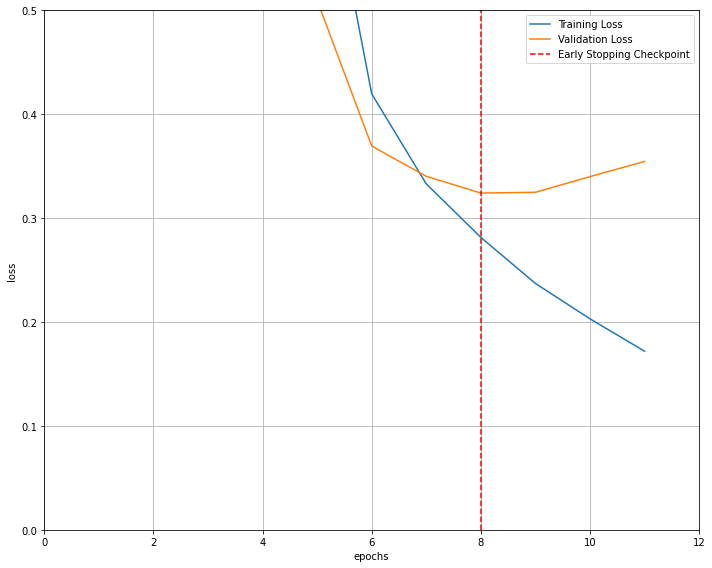

In [21]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'Models/S_loss_plot_cat_v1_1.png', bbox_inches='tight')

In [22]:
torch.save(model.state_dict(), f"Models/BERT_cat_ft_v1_1.model")

In [23]:
"""
1: lr=3e-5 89.5, 0.3546
"""

'\n1: lr=3e-5\n'